# CBO Applied to RL

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import seaborn as sns
import matplotlib.colors as colors
%matplotlib inline
plt.style.use('default')
# plt.style.use('seaborn-darkgrid')
mpl.rcParams['figure.dpi'] = 120

In [75]:
# hacky way of toggling between showing/hiding progress bar

# show
from tqdm.auto import tqdm, trange
# hide
# trange = lambda x, leave=None, desc=None: range(x)
# tqdm = lambda x, leave=None, desc=None: x

## $V$ -evaluation, continuous state space (5.1.)

### Outline

- Markov decision process with a continuous state space $\mathbb S = \{s \in (0, 2\pi]\}$.
- Dynamics described by 

$$\begin{aligned}
&s_{m+1} = s_{m} + \alpha(s_m)\epsilon + \sigma(s_m)\sqrt{\epsilon} Z_m\\
&\alpha(s) = 2 \sin(s) \cos(s), \quad \sigma(s) = 1 + \cos(s)^2, \quad \epsilon = 0.1
\end{aligned}$$

- Immediate reward function, $R(s)=(\cos(2s)+1)$.
- Discount factor $\gamma=0.9$.
- 3 layer FCNN, $V(s;\theta)$. Two hidden layers with $\cos$ activation function, and each hidden layer contains 50 neurons.

$$\begin{aligned}
&V(s ; \theta)=V\left(x ;\left\{w_{i}, b_{i}\right\}_{i=1}^{3}\right)=L_{w_{3}, b_{3}} \circ \cos \circ L_{w_{2}, b_{2}} \circ \cos \circ L_{w_{1}, b_{1}}((\cos s, \sin s)) \\
&L_{w_{i}, b_{i}}(x)=w_{i} x+b_{i}, \quad w_{i} \in \mathbb{R}^{n_{i-1} \times n_{i}}, \quad b_{i} \in \mathbb{R}^{n_{i}}, \quad n_{0}=2, n_{1}=n_{2}=50, n_{3}=1
\end{aligned}$$

- $\theta^*$ is computed with Algorithms 1-4 based on trajectory $\{s_m\}_{m=1}^{10^6}$ with

$$
f\left(s_{m}, s_{m+1}, \theta\right)=R\left(s_{m}\right)+\gamma V\left(s_{m+1} ; \theta\right)-V\left(s_{m} ; \theta\right), \quad \tau=0.1, \quad M=1000
$$

- The SGD algorithm runs for a single epoch with the same initialization $\theta_0$. 
- Error at step $k$, $e_k$ is defined as $e_k=\| V(\cdot,\theta_k)-V^*\|_{L^2}$. 
- Reference $V^*(s)$ is computed by running Algorithm 1 for 10 epochs based on longer trajectory $\{s_m\}_{m=1}^{10^7}$, with $\tau=0.01$, $M=1000$.
- Visualize $\log_{10}(e_k/e_0)$.

Made one modification to paper:
- Since $V(s,\theta)\mapsto V(s,\theta)+\delta$ is a symmetry in $f$, then, a better way of measuring error, $e_k$, is 
$$
e_k=\| V(\cdot,\theta_k)-V^* - \mu_k \|_2,\quad \mu_k = \int V(\cdot,\theta_k)-V^*
$$

### Sampling Trajectory

In [3]:
def sample_trajectory(s_0, α, σ, ϵ, m):
    """
    samples trajectory of a particle following dSₜ = α(t) dt + σ(t) Wₜ, approximated by discrete units of time.
    
    parameters:
    s_0  : Starting state of particle
    α    : Drift function
    σ    : Noise scale function
    ϵ    : Step size
    m    : Number of steps to sample
    
    returns:
    S:   torch.tensor of sampled trajectory, with size (m, *s_0.size())
    """
    s_0_size = s_0.size()
    S = torch.zeros(m, *s_0_size)
    S[0] = s_0
    for i in range(m-1):
        S[i+1] = S[i]+α(S[i])*ϵ+σ(S[i])*torch.sqrt(ϵ)*torch.normal(mean=torch.zeros(*s_0_size))
    return S

In [4]:
α = lambda s: 2*torch.sin(s)*torch.cos(s) 
σ = lambda s: 1+torch.cos(s)**2
ϵ = torch.tensor([0.1])
s_0 = torch.tensor([0.])
r = lambda s: torch.cos(2*s)+1

In [5]:
# S = sample_trajectory(s_0, α, σ, ϵ, int(1e6))
# R = r(S) 
# S_long = sample_trajectory(s_0, α, σ, ϵ, int(1e7))
# R_long = r(S_long) 

In [6]:
# torch.save(S_long, 'S_long.pt')
# torch.save(R_long, 'R_long.pt')
# torch.save(S, 'S.pt')
# torch.save(R, 'R.pt')

In [7]:
S_long = torch.load('S_long.pt')
R_long = torch.load('R_long.pt')
S = torch.load('S.pt')
R = torch.load('R.pt')

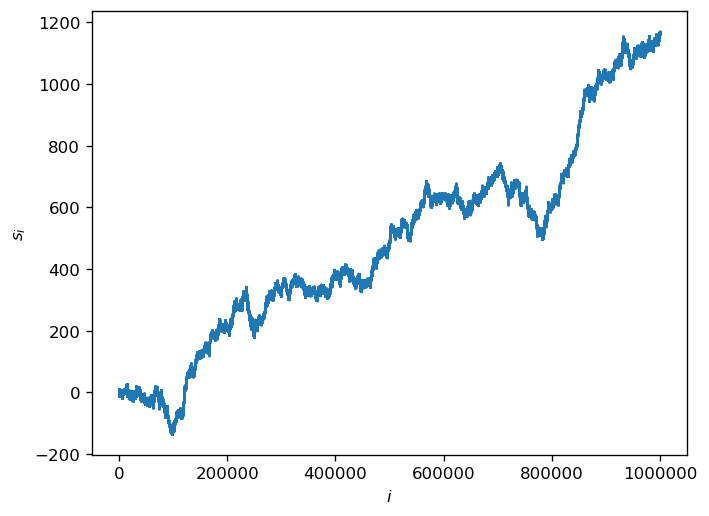

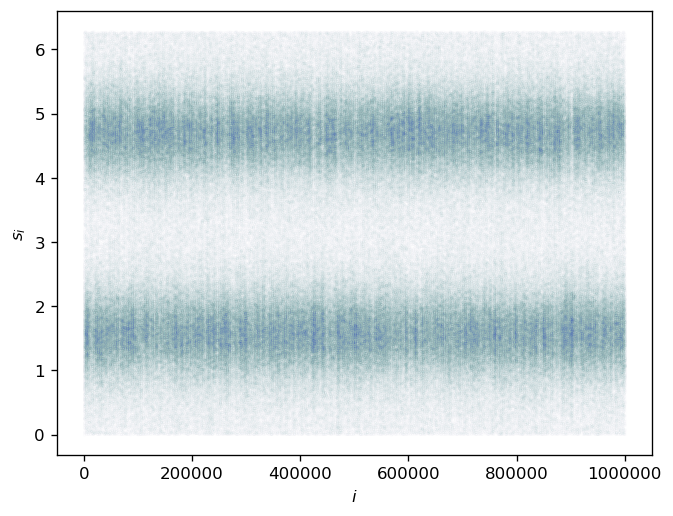

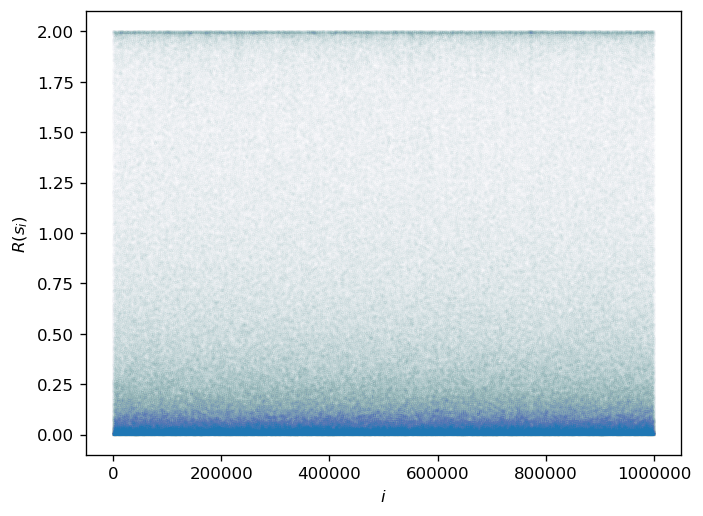

In [8]:
plt.plot(S,".",markersize=0.1);
plt.xlabel(r"$i$");
plt.ylabel(r"$s_i$");
plt.show();
plt.plot(torch.remainder(S,2*np.pi),".",markersize=0.1,alpha=0.1);
plt.xlabel(r"$i$");
plt.ylabel(r"$s_i$");
plt.show();
plt.plot(R,".",markersize=0.1,alpha=0.1);
plt.xlabel(r"$i$");
plt.ylabel(r"$R(s_i)$");
plt.show();

### Algos 1-4

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 50) 
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 1)

    def forward(self, x):
        x = torch.cat((torch.sin(x), torch.cos(x)), 1)
        x = torch.cos(self.fc1(x))
        x = torch.cos(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
def gen_batches(N, M, Rem):
    """
    generate random batches of indices, keeping track of remainders
    
    parameters:
    N   : number of elements to choose from
    M   : size of batches
    Rem : previous remainder
    
    returns:
    B   : tensor of batches, of size q,M 
    Rem : new remainder
    """
    P = torch.randperm(N)
    if Rem.size()[0] > 0:
        I = torch.cat((Rem, P), 0)
    else:
        I = P
    q = int(np.floor((P.size()[0]+Rem.size()[0])/M))
    B = I[:(q*M)].view(q, M)
    Rem = I[(q*M):]
    return B, Rem

In [11]:
def comp(V_net,V_net_comp,x_ls, n):
    diff = V_net(x_ls)-V_net_comp(x_ls)
    return np.sqrt(2*np.pi/n)*torch.norm(diff-torch.mean(diff))
def comp_0(V_net,V_net_comp,x_ls, n):
    return np.sqrt(2*np.pi/n)*torch.norm(V_net(x_ls)-V_net_comp(x_ls))

In [12]:
def algorithm_1(V_net, M, epochs,γ,τ, S, R, α,σ,ϵ, V_net_comp=None, n=100):
    Rem = torch.tensor([])
    N = S.size()[0]
    if V_net_comp:
        x_ls = torch.linspace(0,2*np.pi,n+1)[:-1].view(-1,1)
        e = [comp(V_net,V_net_comp,x_ls, n)]
    for k in trange(epochs, leave=False,desc="Epoch"):
        B, Rem = gen_batches(N-1,M, Rem)
        for i,B_θ in enumerate(tqdm(B,leave=False,desc="Batch")): 
            s = S[B_θ]
            s_1 = S[B_θ+1]
            ŝ_1 = s+α(s)*ϵ+σ(s)*torch.sqrt(ϵ)*torch.normal(mean=torch.zeros_like(s))
            f_p = R[B_θ] + γ*V_net(ŝ_1) - V_net(s)
            f = R[B_θ] + γ*V_net(s_1) - V_net(s)
            V_net.zero_grad()
            f_p.backward(f)
            with torch.no_grad():
                for param in V_net.parameters():
                    param -= τ/M*param.grad
            if V_net_comp:
                e.append(comp(V_net,V_net_comp,x_ls, n))
    if V_net_comp:
        return V_net, torch.tensor(e)
    else:
        return V_net

In [13]:
def algorithm_2(V_net, M, epochs,γ,τ, S, R, V_net_comp=None, n=100):
    Rem = torch.tensor([])
    N = S.size()[0]
    if V_net_comp:
        x_ls = torch.linspace(0,2*np.pi,n+1)[:-1].view(-1,1)
        e = [comp(V_net,V_net_comp,x_ls, n)]
    for k in trange(epochs, leave=False, desc="Epoch"):
        B, Rem = gen_batches(N-1,M, Rem)
        for i, B_θ in enumerate(tqdm(B,leave=False,desc="Batch")):
            s = S[B_θ]
            s_1 = S[B_θ+1]
            f = R[B_θ] + γ*V_net(s_1) - V_net(s)
            V_net.zero_grad()
            f.backward(f)
            with torch.no_grad():
                for param in V_net.parameters():
                    param -= τ/M*param.grad
            if V_net_comp:
                e.append(comp(V_net,V_net_comp,x_ls, n))
    if V_net_comp:
        return V_net, torch.tensor(e)
    else:
        return V_net

In [14]:
def algorithm_3(V_net, M, epochs,γ,τ, S, R, V_net_comp=None, n=100):
    Rem = torch.tensor([])
    N = S.size()[0]
    if V_net_comp:
        x_ls = torch.linspace(0,2*np.pi,n+1)[:-1].view(-1,1)
        e = [comp(V_net,V_net_comp,x_ls, n)]
    for k in trange(epochs, leave=False, desc="Epoch"):
        B, Rem = gen_batches(N-2,M, Rem)
        for i, B_θ in enumerate(tqdm(B,leave=False,desc="Batch")):
            s = S[B_θ]
            s_1 = S[B_θ+1]
            s_2 = S[B_θ+2]
            s̃_1 = s + s_2 - s_1 
            f = R[B_θ] + γ*V_net(s_1) - V_net(s)
            f̃ = R[B_θ] + γ*V_net(s̃_1) - V_net(s)
            V_net.zero_grad()
            (f*f̃).backward(torch.ones_like(f)/2.)
            with torch.no_grad():
                for param in V_net.parameters():
                    param -= τ/M*param.grad
            if V_net_comp:
                e.append(comp(V_net,V_net_comp,x_ls, n))
    if V_net_comp:
        return V_net, torch.tensor(e)
    else:
        return V_net

In [15]:
def algorithm_4(V_net, M, epochs,γ,τ, S, R, V_net_comp=None, n=100):
    Rem = torch.tensor([])
    N = S.size()[0]
    if V_net_comp:
        x_ls = torch.linspace(0,2*np.pi,n+1)[:-1].view(-1,1)
        e = [comp(V_net,V_net_comp,x_ls, n)]
    for k in trange(epochs, leave=False, desc="Epoch"):
        B, Rem = gen_batches(N-2,M, Rem)
        for i, B_θ in enumerate(tqdm(B,leave=False,desc="Batch")):
            s = S[B_θ]
            s_1 = S[B_θ+1]
            s_2 = S[B_θ+2]
            s̃_1 = s + s_2 - s_1 
            f = R[B_θ] + γ*V_net(s_1) - V_net(s)
            f̃ = R[B_θ] + γ*V_net(s̃_1) - V_net(s)
            V_net.zero_grad()
            f̃.backward(f)
            with torch.no_grad():
                for param in V_net.parameters():
                    param -= τ/M*param.grad
            if V_net_comp:
                e.append(comp(V_net,V_net_comp,x_ls, n))
    if V_net_comp:
        return V_net, torch.tensor(e)
    else:
        return V_net

In [16]:
# V_star = Net()
# M = 1000
# epochs = 10
# γ = 0.9
# τ = 0.01
# V_star = algorithm_1(V_star,M,epochs,γ,τ,S_long,R_long,α,σ,ϵ)

In [17]:
# torch.save(V_star, "V_star.pt")

In [18]:
V_star = torch.load("V_star.pt")

In [19]:
M = 1000
epochs = 1
γ = 0.9
τ = 0.1
n = 100
V_1 = Net()
V_1,e_1 = algorithm_1(V_1,M,epochs,γ,τ,S,R,α,σ,ϵ, V_star, n)
V_2 = Net()
V_2,e_2 = algorithm_2(V_2,M,epochs,γ,τ,S,R,V_star,n)
V_3 = Net()
V_3,e_3 = algorithm_3(V_3,M,epochs,γ,τ,S,R,V_star,n)
V_4 = Net()
V_4,e_4 = algorithm_4(V_4,M,epochs,γ,τ,S,R,V_star,n)

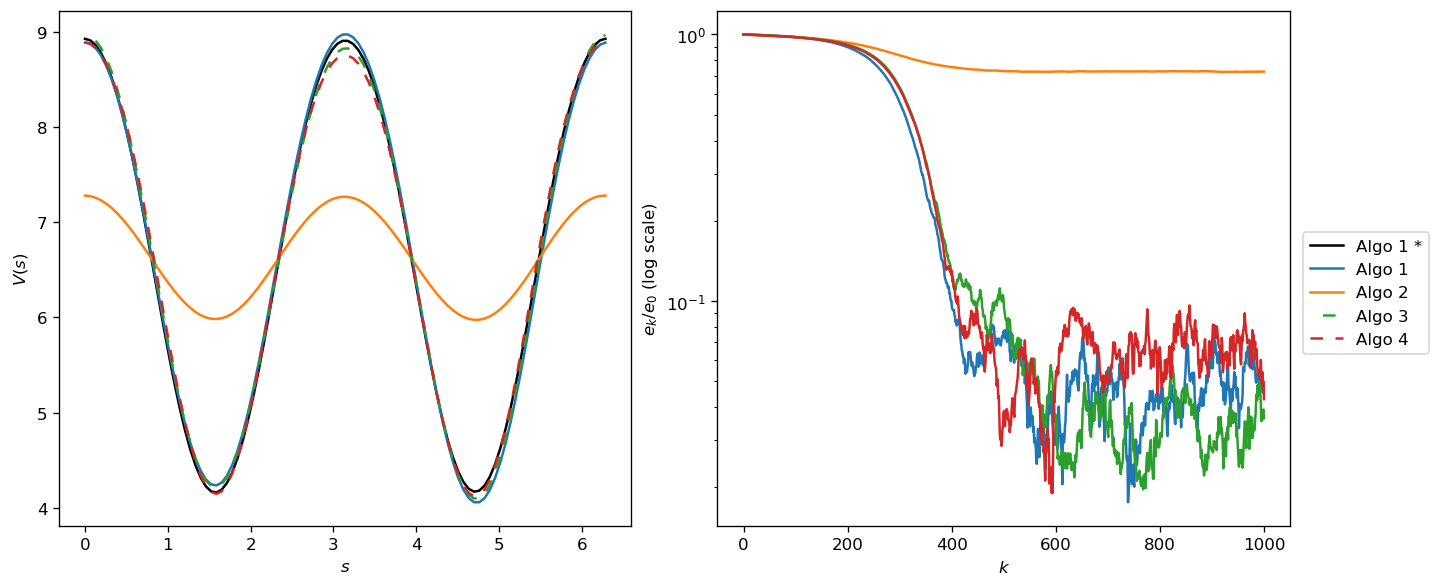

In [20]:
fig, axs = plt.subplots(figsize=(12,5),ncols=2)
x_ls = torch.linspace(0,2*np.pi,100)
y_star_ls = V_star(x_ls.view(-1,1)).view(-1)
y_ls = torch.cat([V(x_ls.view(-1,1)).view(1,-1) for V in [V_1,V_2,V_3,V_4]])
y_ls -= torch.mean(y_ls-y_star_ls.view(1,-1),axis=1).view(-1,1)
e_ls = [e_1,e_2,e_3,e_4]
colors = ["tab:blue", "tab:orange","tab:green","tab:red"]
labels = ["Algo 1", "Algo 2", "Algo 3", "Algo 4"]
line_styles = ['solid','solid',(5,(5,5)),(0,(5,5))]
axs[0].plot(x_ls.detach().numpy(),y_star_ls.detach().numpy(),label="Algo 1 *",color="black")
for j in range(0,len(y_ls)):
    axs[0].plot(x_ls.detach().numpy(),y_ls[j].detach().numpy(),label=labels[j],color=colors[j], ls=line_styles[j])
    axs[1].plot(e_ls[j]/e_ls[j][0], label=labels[j],color=colors[j])
axs[0].set_ylabel(r"$V(s)$")
axs[0].set_xlabel(r"$s$")
axs[1].set_yscale("log")
axs[1].set_ylabel(r"$e_k/e_0$ (log scale)")
axs[1].set_xlabel(r"$k$")
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
plt.tight_layout()
plt.subplots_adjust(right=0.9)

### CBO

In [21]:
def algorithm_CBO(V_net, V_s, S, M, m, epochs, γ,λ,τ,η, β_k, V_net_comp=None, n_comp=100):
    '''
    Implementation of CBO algorithm to minimize
    J = E[(1/2)E[f(s_{m},s_{m+1};θ)|s_{m}]^2]
    
    Parameters:
        V_net      : Net class 
        V_s        : List of Nets (corresponding to particles in CBO)
        S          : Sample trajectory
        M          : Size of batches in X
        m          : Size of batches in S (set to S.size()[0] for no approximations)
        epochs     : Number of epochs
        γ          : Discount factor
        λ          : Exploitation rate
        τ          : Exploration rate
        η          : Learning rate          
        β_k        : 1/(Characteristic energy), as a function of epochs
        V_net_comp : Net to compare V_net to
        n_comp     : Number of points to use to compare V_net and V_net_comp
        
    Returns:
        V_net      : Net class
        e          : Errors, computed each batch
    '''
    with torch.no_grad():
        Rem = torch.tensor([])
        L = torch.empty(M)
        N = len(V_s)
        n = S.size()[0]
        if V_net_comp:
            x_ls = torch.linspace(0,2*np.pi,n+1)[:-1].view(-1,1)
            e = [comp(V_net,V_net_comp,x_ls, n_comp)]
        for k in trange(epochs, leave=False, desc="Epoch"):
            B, Rem = gen_batches(N,M, Rem)
            β = β_k(k)
            τ = τ_k(k)  
            for i, B_θ in enumerate(tqdm(B,leave=False,desc="Batch")):
                A_θ = torch.randperm(n-1)[:m]
                s = S[A_θ]
                s_1 = S[A_θ+1]
                V_θ = [V_j for j,V_j in enumerate(V_s) if j in B_θ]
                f = torch.cat([R[A_θ] + γ*V_j(s_1)-V_j(s) for V_j in V_θ],1)
                L = torch.sum(f**2,0)/(2*m)
                mu = torch.exp(-β*L)
                for xX in zip(V_net.parameters(),*[V_j.parameters() for V_j in V_θ]):
                    xX_tensor = torch.cat([xX_j.view(1,-1) for xX_j in xX])
                    x_new = xX_tensor[0]
                    X_new = xX_tensor[1:]
                    x_new = mu.view(1,-1).mm(X_new)/torch.sum(mu)
                    X_new += -λ*η*(X_new-x_new)+τ*np.sqrt(η)*torch.normal(torch.zeros(X_new.size()))*(X_new-x_new)
                    xX_new = torch.cat((x_new,X_new)).view(-1, *xX[0].size())
                    for xX_j, xX_new_j in zip(xX,xX_new):
                        xX_j +=  xX_new_j - xX_j
                if V_net_comp:
                    e.append(comp(V_net,V_net_comp,x_ls, n_comp))
        if V_net_comp:
            return V_net, torch.tensor(e)
        else:
            return V_net

In [22]:
def algorithm_CBO_UR(V_net, V_s, S, α,σ, M, m, epochs, γ,λ,τ,η,β_k, V_net_comp=None, n_comp=100):
    '''
    Implementation of CBO algorithm to minimize 
    Ĵ = E[(1/2)E[f(s_{m},s_{m+1};θ)|s_{m}]E[f(s_{m},ŝ_{m+1};θ)|s_{m}]]
    where ŝ_{m+1} is generated from the dynamics, α, and σ
    Parameters:
        V_net      : Net class 
        V_s        : List of Nets (corresponding to particles in CBO)
        S          : Sample trajectory
        α          : Drift function
        σ          : Noise scale function
        M          : Size of batches in X
        m          : Size of batches in S (set to S.size()[0] for no approximations)
        epochs     : Number of epochs
        γ          : Discount factor
        λ          : Exploitation rate
        τ          : Exploration rate
        η          : Learning rate          
        β_k          : 1/(Characteristic energy), as a function of epochs
        V_net_comp : Net to compare V_net to
        n_comp     : Number of points to use to compare V_net and V_net_comp
        
    Returns:
        V_net      : Net class
        e          : Errors, computed each batch
    '''
    with torch.no_grad():
        Rem = torch.tensor([])
        L = torch.empty(M)
        N = len(V_s)
        n = S.size()[0]
        if V_net_comp:
            x_ls = torch.linspace(0,2*np.pi,n+1)[:-1].view(-1,1)
            e = [comp(V_net,V_net_comp,x_ls, n_comp)]
        for k in trange(epochs, leave=False, desc="Epoch"):
            B, Rem = gen_batches(N,M, Rem)
            β = β_k(k)
            τ = τ_k(k)  
            for i, B_θ in enumerate(tqdm(B,leave=False,desc="Batch")):
                A_θ = torch.randperm(n-2)[:m]
                s = S[A_θ]
                s_1 = S[A_θ+1]
                s_2 = S[A_θ+2]
                ŝ_1 = s+α(s)*ϵ+σ(s)*torch.sqrt(ϵ)*torch.normal(mean=torch.zeros_like(s))
                V_θ = [V_j for j,V_j in enumerate(V_s) if j in B_θ]
                f = torch.cat([R[A_θ] + γ*V_j(s_1)-V_j(s) for V_j in V_θ],1)
                f̂ = torch.cat([R[A_θ] + γ*V_j(ŝ_1)-V_j(s) for V_j in V_θ],1)
                L = torch.sum(f*f̂,0)/(2*m)
                mu = torch.exp(-β*L)
                for xX in zip(V_net.parameters(),*[V_j.parameters() for V_j in V_θ]):
                    xX_tensor = torch.cat([xX_j.view(1,-1) for xX_j in xX])
                    x_new = xX_tensor[0]
                    X_new = xX_tensor[1:]
                    x_new = mu.view(1,-1).mm(X_new)/torch.sum(mu)
                    X_new += -λ*η*(X_new-x_new)+τ*np.sqrt(η)*torch.normal(torch.zeros(X_new.size()))*(X_new-x_new)
                    xX_new = torch.cat((x_new,X_new)).view(-1, *xX[0].size())
                    for xX_j, xX_new_j in zip(xX,xX_new):
                        xX_j +=  xX_new_j - xX_j
                if V_net_comp:
                    e.append(comp(V_net,V_net_comp,x_ls, n_comp))
        if V_net_comp:
            return V_net, torch.tensor(e)
        else:
            return V_net

In [23]:
def algorithm_CBO_BFF(V_net, V_s, S, M, m, epochs, γ,λ,τ,η,β_k, V_net_comp=None, n_comp=100):
    '''
    Implementation of CBO algorithm to minimize J̃ = E[(1/2)E[f(s_{m},s_{m+1};θ)|s_{m}]E[f(s_{m},s̃_{m+1};θ)|s_{m}]]
    
    Parameters:
        V_net      : Net class 
        V_s        : List of Nets (corresponding to particles in CBO)
        S          : Sample trajectory
        M          : Size of batches in X
        m          : Size of batches in S (set to S.size()[0] for no approximations)
        epochs     : Number of epochs
        γ          : Discount factor
        λ          : Exploitation rate
        τ          : Exploration rate
        η          : Learning rate          
        β_k          : 1/(Characteristic energy), as a function of epochs
        V_net_comp : Net to compare V_net to
        n_comp     : Number of points to use to compare V_net and V_net_comp
        
    Returns:
        V_net      : Net class
        e          : Errors, computed each batch
    '''
    with torch.no_grad():
        Rem = torch.tensor([])
        L = torch.empty(M)
        N = len(V_s)
        n = S.size()[0]
        if V_net_comp:
            x_ls = torch.linspace(0,2*np.pi,n+1)[:-1].view(-1,1)
            e = [comp(V_net,V_net_comp,x_ls, n_comp)]
        for k in trange(epochs, leave=False, desc="Epoch"):
            B, Rem = gen_batches(N,M, Rem)
            β = β_k(k)
            τ = τ_k(k)  
            for i, B_θ in enumerate(tqdm(B,leave=False,desc="Batch")):
                A_θ = torch.randperm(n-2)[:m]
                s = S[A_θ]
                s_1 = S[A_θ+1]
                s_2 = S[A_θ+2]
                s̃_1 = s + s_2 - s_1
                V_θ = [V_j for j,V_j in enumerate(V_s) if j in B_θ]
                f = torch.cat([R[A_θ] + γ*V_j(s_1)-V_j(s) for V_j in V_θ],1)
                f̃ = torch.cat([R[A_θ] + γ*V_j(s̃_1)-V_j(s) for V_j in V_θ],1)
                L = torch.sum(f*f̃,0)/(2*m)
                mu = torch.exp(-β*L)
                for xX in zip(V_net.parameters(),*[V_j.parameters() for V_j in V_θ]):
                    xX_tensor = torch.cat([xX_j.view(1,-1) for xX_j in xX])
                    x_new = xX_tensor[0]
                    X_new = xX_tensor[1:]
                    x_new = mu.view(1,-1).mm(X_new)/torch.sum(mu)
                    X_new += -λ*η*(X_new-x_new)+τ*np.sqrt(η)*torch.normal(torch.zeros(X_new.size()))*(X_new-x_new)
                    xX_new = torch.cat((x_new,X_new)).view(-1, *xX[0].size())
                    for xX_j, xX_new_j in zip(xX,xX_new):
                        xX_j +=  xX_new_j - xX_j
                if V_net_comp:
                    e.append(comp(V_net,V_net_comp,x_ls, n_comp))
        if V_net_comp:
            return V_net, torch.tensor(e)
        else:
            return V_net

In [132]:
N = int(1e2)
M = int(1e2)
m = int(1e4)
epochs = 800
λ = 1.
η = 0.005
τ_k = lambda k: max(5*0.995**k, 0)
β_k = lambda k: min(10*1.005**k,400.)

In [133]:
print(β_k(epochs),τ_k(epochs))

400.0 0.09066394262332035


In [134]:
V_s = [Net() for _ in range(N)]
V_CBO, e_CBO = algorithm_CBO(Net(), V_s, S, M, m, epochs, 0.9,λ,τ_k,η, β_k, V_net_comp=V_star, n_comp=100)

In [135]:
V_s = [Net() for _ in range(N)]
V_CBO_UR, e_CBO_UR = algorithm_CBO_UR(Net(), V_s, S, α,σ, M, m, epochs, 0.9,λ,τ_k,η, β_k, V_net_comp=V_star, n_comp=100)

In [136]:
V_s = [Net() for _ in range(N)]
V_CBO_BFF, e_CBO_BFF = algorithm_CBO_BFF(Net(), V_s, S, M, m, epochs, 0.9,λ,τ,η, β_k, V_net_comp=V_star, n_comp=100)

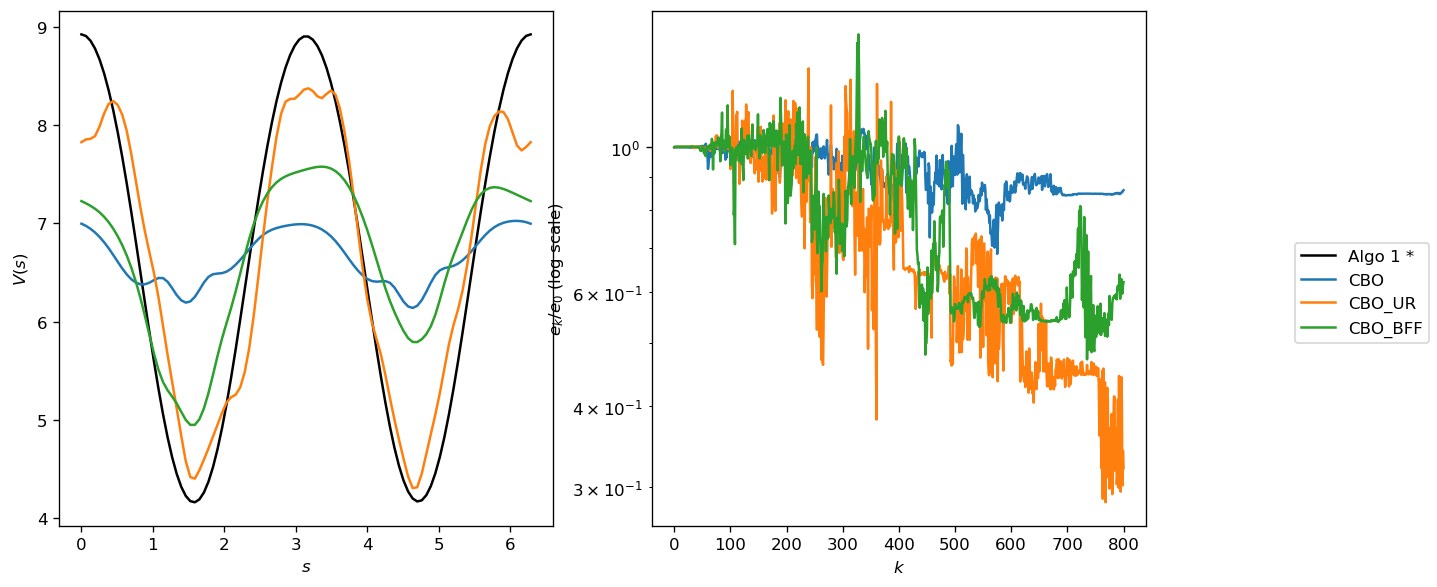

In [137]:
V_ls = [V_CBO,V_CBO_UR,V_CBO_BFF]
e_ls = [e_CBO,e_CBO_UR, e_CBO_BFF]
labels = ["CBO","CBO_UR","CBO_BFF"]
fig, axs = plt.subplots(figsize=(12,5),ncols=2)
x_ls = torch.linspace(0,2*np.pi,100)
y_star_ls = V_star(x_ls.view(-1,1)).view(-1)
y_ls = torch.cat([V(x_ls.view(-1,1)).view(1,-1) for V in V_ls])
y_ls -= torch.mean(y_ls-y_star_ls.view(1,-1),axis=1).view(-1,1)
axs[0].plot(x_ls.detach().numpy(),y_star_ls.detach().numpy(),label="Algo 1 *",color="black")
for j in range(0,len(y_ls)):
    axs[0].plot(x_ls.detach().numpy(),y_ls[j].detach().numpy(),label=labels[j])
    axs[1].plot(e_ls[j]/e_ls[j][0], label=labels[j])
axs[0].set_ylabel(r"$V(s)$")
axs[0].set_xlabel(r"$s$")
axs[1].set_yscale("log")
axs[1].set_ylabel(r"$e_k/e_0$ (log scale)")
axs[1].set_xlabel(r"$k$")
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
plt.tight_layout()
plt.subplots_adjust(right=0.8)

## $Q$-evaluation and control, continuous state space (4.1.)

### Outline

- MDP with a continuous state space $\mathbb S = \{s \in (0, 2\pi]\}$.
- Dynamics described by 

$$
\begin{aligned}
&\Delta s_{m} = a_m\epsilon + \sigma \sqrt{\epsilon} Z_m\\
&a_m \in\mathbb A = \{\pm 1\}\\
&a_m\sim \pi(\cdot|s_{m-1})\\
&\varepsilon = \frac{2\pi}{32}\\
&\sigma = 0.2\\
&r(s_{m+1},s_{m},a_m) = \sin(s_{m+1})+1
\end{aligned}
$$

- 3 layer FCNN, $Q^\pi(s,a;\theta)$. Two hidden layers with $\cos$ activation function, and each hidden layer contains 50 neurons. Output layer of size $|\mathbb A|$.

### $Q$-evaluation
Estimating $Q^\pi$ for fixed policy $\pi(a|s)=1/2 + a \sin(s)/5$.
$$j^{eval}(s_m, a_m, s_{m+1};\theta) = r(s_{m+1}, s_m, a_m)  + \gamma \int Q^\pi(s_{m+1},a;\theta)\pi(a|s_{m+1})da - Q^\pi(s_m,a_m;\theta)$$

In [138]:
π = lambda a, s: 1/2 + a*torch.sin(s)/5
σ = 0.2
ϵ = 2.*np.pi/32.
s_0 = torch.tensor([0.])
r = lambda s: torch.sin(s)+1
A = torch.tensor([-1,+1])

In [139]:
from torch.distributions.categorical import Categorical 

In [153]:
def sample_policy(s_0, π, σ, ϵ, A, m):
    """
    samples trajectory of a particle following dSₜ = a(t) dt + σ(t) Wₜ, approximated by discrete units of time,
    where a ~ π(a|s)
    
    parameters:
    s_0  : Starting state of particle
    π    : Policy, function of a,s
    σ    : Noise scale
    ϵ    : Step size
    A    : Action set
    m    : Number of steps to sample
    
    returns:
    S:   torch.tensor of sampled trajectory, with size (m, *s_0.size())
    """
    s_0 = s_0.view(s_0.size()[0],-1)
    s_0_size = s_0.size()
    S = torch.zeros(m,*s_0_size)
    S[0] = s_0
    for i in range(m-1):
        for j, s in enumerate(S[i]):
            a = Categorical(probs=torch.tensor([π(a_,s) for a_ in A])).sample()
            S[i+1,j] = s+a*ϵ+σ*np.sqrt(ϵ)*np.random.normal()
    return S

In [167]:
S = sample_policy(s_0, π, σ, ϵ, A, int(1e4)).view(-1,1)
R = r(S) 
S_long = sample_policy(s_0, π, σ, ϵ, A, int(1e5)).view(-1,1)
R_long = r(S_long) 

In [ ]:
# torch.save(S_long, 'S_long_1.pt')
# torch.save(R_long, 'R_long_1.pt')
# torch.save(S, 'S_1.pt')
# torch.save(R, 'R_1.pt')

In [ ]:
S_long = torch.load('S_long_1.pt')
R_long = torch.load('R_long_1.pt')
S = torch.load('S_1.pt')
R = torch.load('R_1.pt')

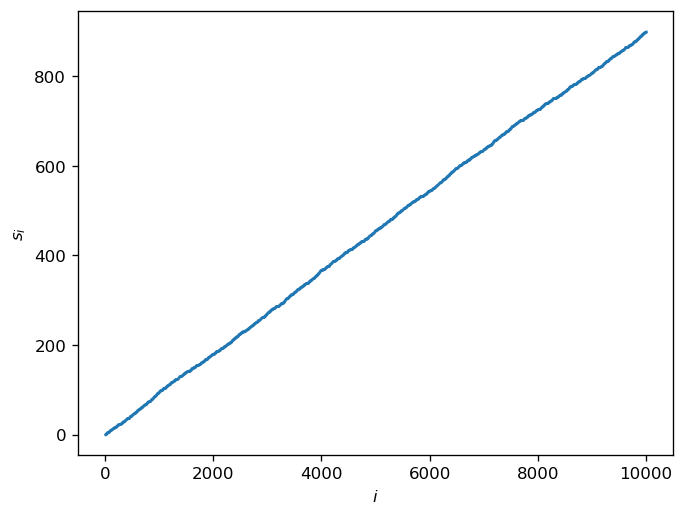

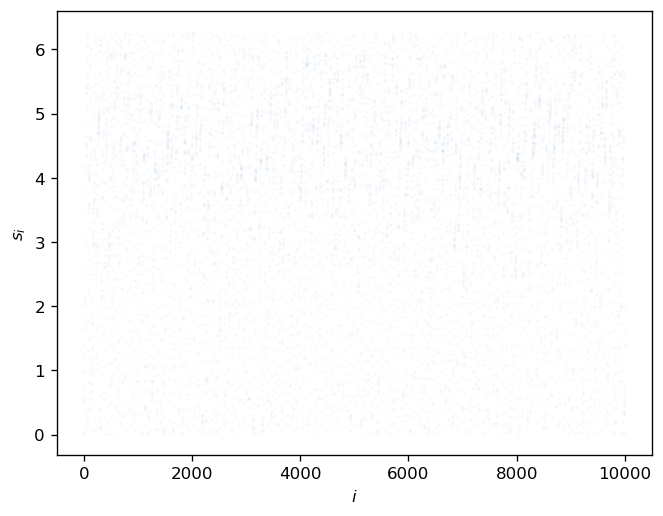

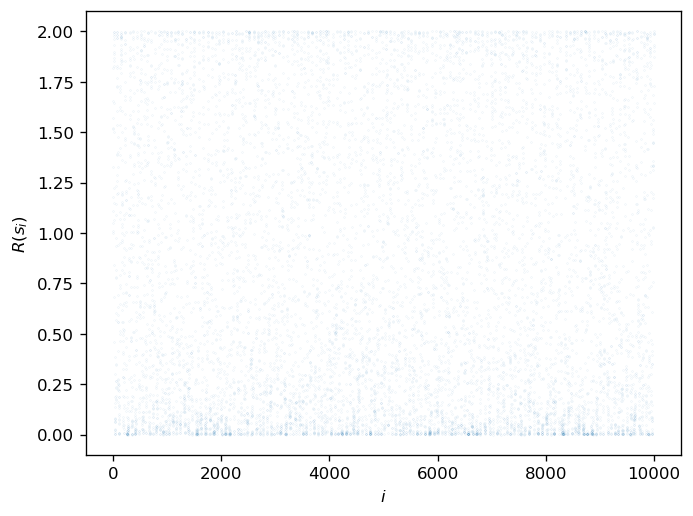

In [168]:
plt.plot(S,".",markersize=0.2);
plt.xlabel(r"$i$");
plt.ylabel(r"$s_i$");
plt.show();
plt.plot(torch.remainder(S,2*np.pi),".",markersize=0.2,alpha=0.2);
plt.xlabel(r"$i$");
plt.ylabel(r"$s_i$");
plt.show();
plt.plot(R,".",markersize=0.3,alpha=0.2);
plt.xlabel(r"$i$");
plt.ylabel(r"$R(s_i)$");
plt.show();

In [169]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 50) 
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 2)

    def forward(self, x):
        x = torch.cat((torch.sin(x), torch.cos(x)), 1)
        x = torch.cos(self.fc1(x))
        x = torch.cos(self.fc2(x))
        x = self.fc3(x)
        return x

In [171]:
def Q_eval_SGD_UR(Q_net, M, epochs,γ,τ, S, R, π,σ,ϵ, Q_net_comp=None, n=100):
    Rem = torch.tensor([])
    N = S.size()[0]
    if Q_net_comp:
        x_ls = torch.linspace(0,2*np.pi,n+1)[:-1].view(-1,1)
        e = [comp(V_net,V_net_comp,x_ls, n)]
    for k in trange(epochs, leave=False,desc="Epoch"):
        B, Rem = gen_batches(N-1,M, Rem)
        for i,B_θ in enumerate(tqdm(B,leave=False,desc="Batch")): 
            s = S[B_θ]
            s_1 = S[B_θ+1]
            a = Categorical(probs=torch.tensor([π(a_,s) for a_ in A])).sample()
            ŝ_1 = s+a*ϵ+σ*np.sqrt(ϵ)*np.random.normal()
            j = R[B_θ] + γ*Q_net(s_1).mm(π)
            ĵ = R[B_θ] + γ*Q_net(ŝ_1).mm(π)
            Q_net.zero_grad()
            ĵ.backward(j)
            with torch.no_grad():
                for param in V_net.parameters():
                    param -= τ/M*param.grad
            if V_net_comp:
                e.append(comp(Q_net,Q_net_comp,x_ls, n))
    if Q_net_comp:
        return Q_net, torch.tensor(e)
    else:
        return Q_net

### $Q$-control

Fixed behaviour policy to genearte training trajectory, $\pi(a|s)=1/|\mathbb A|$.

$$j^{ctrl}(s_m, a_m, s_m+1;\theta) = r(s_{m+1}, s_m, a_m)  + \gamma \max_{a'} Q^\pi(s_{m+1},a';\theta) - Q^\pi(s_m,a_m;\theta)$$